<a href="https://colab.research.google.com/github/AsherReedy/Monte-Carlo-iRisk-Lab-Meetings-and-Homework/blob/main/IRisk_Meeting02_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IRisk — Meeting 2
### Random Generators → Uniform → Normal, and a Monte Carlo VaR/ES Application

**Goals**
- Understand PRNGs and seeding for reproducibility.
- See encryption/decryption with a small RSA pipeline (for learning only).
- Convert Uniform(0,1) to Normal (Box–Muller) and reuse it for an applied MC.
- Estimate VaR and Expected Shortfall (ES/TVaR) and compare to analytic results.


> **Parameters** — edit and then run the notebook top-to-bottom.

In [9]:
import math, time, hashlib, textwrap
import numpy as np
import matplotlib.pyplot as plt

# Global config
SEED = 12                 # change to see different random streams
rng  = np.random.default_rng(SEED)

# Portfolio for VaR/ES (1-day horizon)
V0     = 1_000_000.0        # portfolio value
mu     = 0.0005             # daily mean return
sigma  = 0.015              # daily volatility
alpha  = 0.95               # confidence level
N_PATHS = 50_000            # Monte Carlo paths

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True

print(f'Seed={SEED}, V0=${V0:,.0f}, mu={mu:.4%}, sigma={sigma:.2%}, alpha={alpha}, N={N_PATHS:,}')

Seed=12, V0=$1,000,000, mu=0.0500%, sigma=1.50%, alpha=0.95, N=50,000


---
## A) Pseudo-Random Generators & Seeding

- Computers use deterministic algorithms to mimic randomness (PRNGs).
- A seed fixes the PRNG state so results are repeatable.
- Prefer one `Generator` (`np.random.default_rng(SEED)`) and pass it around.

Checklist to record: seed, sample size, algorithm, and CI method.

---
## B) Encryption/Decryption by Example — Toy RSA

Steps: key generation → encode text into integers < $n$ → encrypt → decrypt → decode.

Math (light): choose primes $p,q$; $n=pq$; $\varphi(n)=(p-1)(q-1)$. Pick $e$ coprime to $\varphi(n)$; compute $d$ such that $ed\equiv1\pmod{\varphi(n)}$.  
- Public key: $(n,e)$ — used to encrypt.  
- Private key: $(d)$ — used to decrypt.

In [10]:
# Helpers: gcd / modular inverse / tiny prime test
def egcd(a, b):
    if b == 0:
        return (a, 1, 0)
    g, x, y = egcd(b, a % b)
    return (g, y, x - (a // b) * y)

def modinv(a, m):
    g, x, _ = egcd(a, m)
    if g != 1:
        raise ValueError("No modular inverse")
    return x % m

def is_probable_prime(n):
    if n < 2:
        return False
    small = [2,3,5,7,11,13,17,19,23,29]
    for p in small:
        if n % p == 0:
            return n == p
    # Miller–Rabin for 32-bit range
    d = n - 1; s = 0
    while d % 2 == 0:
        d //= 2; s += 1
    for a in [2, 7, 61]:
        if a % n == 0:
            continue
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(s - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True

def random_prime(bits=16, rng=np.random.default_rng(0)):
    while True:
        n = int(rng.integers(2**(bits-1), 2**bits-1)) | 1 | (1 << (bits-1))
        if is_probable_prime(n):
            return n

def rsa_keygen(bits=16, rng=np.random.default_rng(0)):
    p = random_prime(bits, rng)
    q = random_prime(bits, rng)
    while q == p:
        q = random_prime(bits, rng)
    n = p*q
    phi = (p-1)*(q-1)
    e = 65537
    if math.gcd(e, phi) != 1:
        e = 3
        while math.gcd(e, phi) != 1:
            e += 2
    d = modinv(e, phi)
    return (n, e), (n, d), (p, q), phi

In [11]:
# Encode text into base-256 integers below n; decode back to text
def max_block_len(n, base=256):
    k = 1
    while base**k < n:
        k += 1
    return k - 1

def encode_message(msg: str, n: int, base=256):
    data = msg.encode("utf-8")
    k = max_block_len(n, base)
    blocks = []
    for i in range(0, len(data), k):
        chunk = data[i:i+k]
        m = 0
        for b in chunk:
            m = m*base + b
        blocks.append(m)
    return blocks, k

def decode_message(blocks, k, base=256):
    out = bytearray()
    for m in blocks:
        tmp = []
        x = m
        for _ in range(k):
            tmp.append(x % base)
            x //= base
        tmp.reverse()
        for b in tmp:
            if b != 0 or len(out) > 0:
                out.append(b)
    return out.decode("utf-8", errors="ignore")

In [12]:
# Encrypt/decrypt each block
def rsa_encrypt_blocks(blocks, pub):
    n, e = pub
    return [pow(m % n, e, n) for m in blocks]

def rsa_decrypt_blocks(cblocks, priv):
    n, d = priv
    return [pow(c, d, n) for c in cblocks]

# Demo
pub, priv, (p,q), phi = rsa_keygen(bits=16, rng=rng)
message = "My name is Asher!!"
m_blocks, k = encode_message(message, pub[0])
c_blocks = rsa_encrypt_blocks(m_blocks, pub)
m2_blocks = rsa_decrypt_blocks(c_blocks, priv)
message_out = decode_message(m2_blocks, k)

print("p,q:", p, q)
print("n:", pub[0], "| phi:", phi)
print("public (n,e):", pub)
print("private (n,d):", (priv[0], "..."))
print("original:", message)
print("cipher blocks (first few):", c_blocks[:5])
print("decrypted:", message_out)
print("ok?", message_out == message)

p,q: 38971 62137
n: 2421541027 | phi: 2421439920
public (n,e): (2421541027, 65537)
private (n,d): (2421541027, '...')
original: My name is Asher!!
cipher blocks (first few): [2174509102, 809730539, 252025244, 1813185289, 514397440]
decrypted: My name is Asher!!
ok? True


Notes: we pack bytes into integers smaller than $n$; encrypt $c=m^e\bmod n$; decrypt $m=c^d\bmod n$. Real RSA uses large keys and padding; this small demo is only for intuition.

---
## C) From Uniform to Normal (Box–Muller)

Two uniforms $U_1,U_2\sim\text{Uniform}(0,1)$ produce two independent $N(0,1)$ values via a polar change of variables.

Key idea: interpret $(U_1,U_2)$ as random radius/angle; rotational symmetry of the normal gives independence.

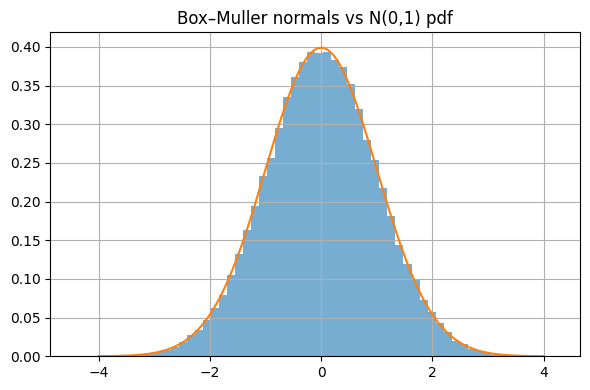

In [13]:
def box_muller_normals(n, rng):
    u1 = rng.random(n//2)
    u2 = rng.random(n//2)
    r  = np.sqrt(-2*np.log(u1))
    th = 2*np.pi*u2
    z1 = r*np.cos(th); z2 = r*np.sin(th)
    return np.concatenate([z1, z2]) if n % 2 == 0 else np.concatenate([z1, z2, rng.standard_normal(1)])

# quick check
Z = box_muller_normals(90_000, rng)
plt.figure(); plt.hist(Z, bins=60, density=True, alpha=0.6)
x = np.linspace(-4,4,401); plt.plot(x, 1/np.sqrt(2*np.pi)*np.exp(-x**2/2))
plt.title("Box–Muller normals vs N(0,1) pdf"); plt.tight_layout(); plt.show()

---
## D) Monte Carlo: One-Day VaR and ES for a Normal-Returns Portfolio

Return $R\sim\mathcal N(\mu,\sigma^2)$; loss $L=-V_0R$. We estimate $\text{VaR}_\alpha$ and $\text{ES}_\alpha$ by simulation and compare to the normal formulas.

VaR explanation: the $\alpha$-quantile of loss — the threshold exceeded with probability $1-\alpha$.

ES explanation: the average loss beyond VaR; also called Tail VaR.

Analytic VaR@0.95: $24,173   ES@0.95: $30,441  (z=1.645)
   Monte Carlo VaR@0.95: $24,044   ES@0.95: $30,486  (N=50,000)


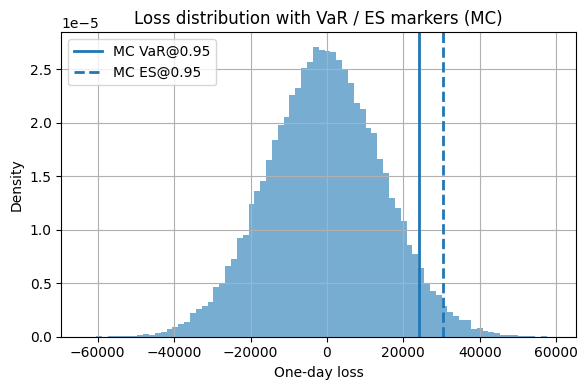

In [14]:
# Normal quantile/pdf helpers (Acklam-style approximation)
def norm_ppf(p):
    a=[-3.969683028665376e+01, 2.209460984245205e+02,-2.759285104469687e+02,
       1.383577518672690e+02,-3.066479806614716e+01, 2.506628277459239e+00]
    b=[-5.447609879822406e+01, 1.615858368580409e+02,-1.556989798598866e+02,
       6.680131188771972e+01,-1.328068155288572e+01]
    c=[-7.784894002430293e-03,-3.223964580411365e-01,-2.400758277161838e+00,
       -2.549732539343734e+00, 4.374664141464968e+00, 2.938163982698783e+00]
    d=[ 7.784695709041462e-03, 3.224671290700398e-01, 2.445134137142996e+00,
        3.754408661907416e+00]
    plow=0.02425; phigh=1-plow
    if not (0 < p < 1):
        raise ValueError("p in (0,1)")
    if p < plow:
        q=math.sqrt(-2*math.log(p))
        return (((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) /                ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)
    if p > phigh:
        q=math.sqrt(-2*math.log(1-p))
        return -(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) /                  ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)
    q=p-0.5; r=q*q
    return (((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q /            (((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)

def norm_pdf(z):
    return (1/np.sqrt(2*np.pi))*np.exp(-0.5*z*z)

def normal_var_es(V0, mu, sigma, alpha):
    z = norm_ppf(alpha)
    var = -V0*mu + V0*sigma*z
    es  = -V0*mu + V0*sigma*(norm_pdf(z)/(1-alpha))
    return float(var), float(es), float(z)

# Monte Carlo using Box–Muller normals
Z = box_muller_normals(N_PATHS, rng)
R = mu + sigma*Z
L = -V0*R

VaR_mc = float(np.quantile(L, alpha))
ES_mc  = float(L[L>=VaR_mc].mean())

VaR_th, ES_th, z = normal_var_es(V0, mu, sigma, alpha)

print(f'Analytic VaR@{alpha:.2f}: ${VaR_th:,.0f}   ES@{alpha:.2f}: ${ES_th:,.0f}  (z={z:.3f})')
print(f'   Monte Carlo VaR@{alpha:.2f}: ${VaR_mc:,.0f}   ES@{alpha:.2f}: ${ES_mc:,.0f}  (N={N_PATHS:,})')

plt.figure()
plt.hist(L, bins=80, density=True, alpha=0.6)
plt.axvline(VaR_mc, linewidth=2, label=f'MC VaR@{alpha:.2f}')
plt.axvline(ES_mc,  linewidth=2, linestyle='--', label=f'MC ES@{alpha:.2f}')
plt.title('Loss distribution with VaR / ES markers (MC)')
plt.xlabel('One-day loss'); plt.ylabel('Density')
plt.legend(); plt.tight_layout(); plt.show()

---
## E) Practice


1. How would you modify `box_muller_normals` so that for every $Z$ you also use $-Z$? Why might this reduce variance for VaR/ES?

Idea: antithetical sampling, sampling variance

**Explanations:**

I modified the amount of uniform rv's we're generating to be n // 4, this is because for each rv, we are creating an antithetical pair to go along with it and so we only need half as many rvs for a given n. In total we're returning 4 Z's, so I modified the return statement to include the antithetical Z's along with the original z1 and z2.


By adding the antithetical counterparts to z1 and z2, we're introducing a negative covariance amongst the pairs. The variance formula between 2 non-independent RV's is: Var(x+y) = Var(x)+Var(y)+2Cov(x,y), so if there is a negative covariance, the pair's variance will be reduced, this creates a more accurate model and reduces variance for predictions of VaR and ES. Overall, the goal is to make the 2 pair values move in opposite directions so their pair-average is more stable and is closer to mew. The results are a symmetrical set of values with a negative covariance between pairs.

There is also a reducion in computational demand because we're generating half as many numbers as we would otherwise.

I found that this strategy pretty much always works if the function is monotonic (entirely non-increasing / non-decreasing), it may not work otherwise. It always works in this case because the normal CDF is monotonic.




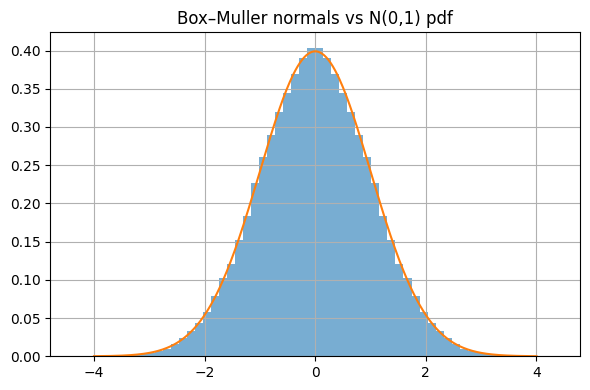

In [15]:
def box_muller_normals(n, rng):
    u1 = rng.random(n//4)  # change n//2 to n//4 bc we are returning 4 z's, only half of them are og numbers, other half are multiplied by -1
    u2 = rng.random(n//4)
    r  = np.sqrt(-2*np.log(u1))
    th = 2*np.pi*u2

    z1 = r*np.cos(th); z2 = r*np.sin(th)

    return np.concatenate([z1, z2, -1*z1, -1*z2]) if n % 2 == 0 else np.concatenate([z1, z2, rng.standard_normal(1)])
    # adding the negative Z's to the return array

# quick check
Z = box_muller_normals(90_000, rng)
plt.figure(); plt.hist(Z, bins=60, density=True, alpha=0.6)
x = np.linspace(-4,4,401); plt.plot(x, 1/np.sqrt(2*np.pi)*np.exp(-x**2/2))
plt.title("Box–Muller normals vs N(0,1) pdf"); plt.tight_layout(); plt.show()

# Symmetrical result

2. Use $U\sim\text{Uniform}(0,1)$ and the provided `norm_ppf(U)` to generate normals. Compare runtime and estimates versus Box–Muller for your VaR task. Which do you prefer and why?

Idea: runtime, computational efficiency

**Explanations:**

The runtime of the Box Muller estimate is much faster than the Inverse CDF method. This is mostly because the Inverse CDF method has to use a for-loop to create the list of all the Normal random variables. Though I think this could be avoided by modifying the norm_ppf method to allow it to return arrays of random variables instead of just one at a time. Additionally, the Box-Muller method is a little bit faster because it is using antithetical sampling which halves the number of random samples it needs to generate.

The estimates from both methods are very similar to each other which is expected because they are both generating RV's from the same normal distribution.

While in this case it's a little slower, I prefer the Inverse CDF method because it's more intuitive to me than the derivation of the Box Muller transformation. Also I think some changes could be made to lower the runtime.

In [17]:
# ppf --> inverse cdf
import time

def Inverse_CDF():
  u = np.random.uniform()
  x = norm_ppf(u)

  return x

def Inverse_CDF_Simulations(n):
  samples = [Inverse_CDF() for _ in range(n)]
  samples = np.array(samples)

  return samples

def Inverse_CDF_var_es(V0, mu, sigma, alpha, n_paths):
    start_time = time.perf_counter()

    samples = Inverse_CDF_Simulations(n_paths)
    losses = -V0 * (mu + sigma * samples)

    VaR = np.quantile(losses, alpha)
    ES  = losses[losses >= VaR].mean()

    end_time = time.perf_counter()
    elapsed = end_time - start_time

    return float(VaR), float(ES), elapsed

def Box_Muller_var_es(V0, mu, sigma, alpha, n_paths):
    start_time = time.perf_counter()

    samples = box_muller_normals(n_paths, rng)
    losses = -V0 * (mu + sigma * samples)

    VaR = np.quantile(losses, alpha)
    ES  = losses[losses >= VaR].mean()

    end_time = time.perf_counter()
    elapsed = end_time - start_time

    return float(VaR), float(ES), elapsed


V0     = 1_000_000.0   # portfolio value
mu     = 0.0005        # daily mean return
sigma  = 0.015         # daily volatility
alpha  = 0.95          # confidence level
N_PATHS = 50_000       # Monte Carlo paths

VaR_mc, ES_mc, runtime = Inverse_CDF_var_es(V0, mu, sigma, alpha, N_PATHS)
print(f"Inverse CDF VaR (α={alpha:.0%}): {VaR_mc:,.2f}")
print(f"Inverse CDF ES  (α={alpha:.0%}): {ES_mc:,.2f}")
print(f"Runtime: {runtime:.5f} seconds\n")

VaR_mc, ES_mc, runtime = Box_Muller_var_es(V0, mu, sigma, alpha, N_PATHS)
print(f"Box Muller VaR (α={alpha:.0%}): {VaR_mc:,.2f}")
print(f"Box Muller ES  (α={alpha:.0%}): {ES_mc:,.2f}")
print(f"Runtime: {runtime:.5f} seconds")


Inverse CDF VaR (α=95%): 24,041.70
Inverse CDF ES  (α=95%): 30,448.87
Runtime: 0.22675 seconds

Box Muller VaR (α=95%): 24,007.15
Box Muller ES  (α=95%): 30,193.67
Runtime: 0.00251 seconds


3. Explain why a regulator cares about value at risk and how it is used.

Idea: Risk management, Reserving, Basel Accords

**Explantions:**

In the context of Risk-Management, the value of risk can indicate the potential loss at a specific confidence level. For example, a 95% VaR of X tells us that there is a 95% chance we won't lose more than $X, and a 5% chance of a loss greater than $X. It is the same as the percentile.

Regulators care about VaR because it is a good general measure of risk and can provide insights into potential losses for banks or insurance companies. By predicting VaR, financial institutions can plan ahead and set aside reserves according to the level of risk to protect themselves from going bankrupt.

Basel 2 required banks to calculate VaR and follow specific guidelines, later on, in response to the 2008 financial crisis, this was expanded upon and some updates were made in Basel 2.5 and 3.


4. Look up a different technique for encryption. Describe its benefits and drawbacks.

Idea: Elliptic-Curve, Lattice-Based, Quantum, Caesar Cipher

**Explanations:**

Quantum Cryptography

This methods uses principles of quantum mechanics to create and send encryption keys through a process called QKD, it involves sending photons of different polarization and where there is information hidden in the pattern of photon polarizations.

secure, observing a quantum state changes it, the recepient will know if someone tried to intercept it

Benefits:

  - The encryption is totally secure because observing a quantum state changes the state so the recepient and sender will know if the photons were tampered with by an eavesdropper.
  - Even if an eavesdropper got ahold of the message, they wouldn't be able to decode it.
  - Quantum random number generators are truly random.


Drawbacks:

  - There's still lots of work and research that needs to be done to implement the technology on a wide scale.
  - The hardware requires lots of resources and it is very expensive to implement on a large scale.


It's kind of interesting there seems to be a lot of talk about cyber risk in the insurance industry, if quantum cryptography gets to the point where it can be implemented it would help prevent many big losses.


5. Pair up with another group member and share your solutions to #2 on HW1 (an example using repeated random draws). Describe your partner’s example and compare it to your own.

**Explanations:**

I paired up with Lucian, for his example he used random draws to estimate the area inside a parabola bounded by y = 1 and 0 <= x <= 1 (half parabola). He simulated values for x and y using a uniform rng and kept track of the points that landed inside the parabola through the inequality: inside = x^2 - y <= 0. He took the proportion of points over the total points drawn to approximate the area inside the parabola.
